<a href="https://colab.research.google.com/github/revurpk/csci-s89-deep-learning/blob/main/CSCI_S_89_Final_Project_Pradyumna_Revur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NAME: Pradyumna Revur
# CSCI S-89 DEEP LEARNING (Summer 2025)
## Final Project
### Topic: Case Study in Speech Recognition
<hr/>

## Table of Contents
* [Introduction](#introduction)
* [Import the dataset](#importing-the-dataset)
* [Prepare vocabulary](#prepare-vocabulary)
* [Preprocess](#preprocessing)
* [Create input pipelines](#input-pipelines)
* [Visualize the data](#visualize-data)
* [Define the model](#define-model)
* [Train and Evaluate](#train-and-evaluate)
* [Plot training and validation loss](#plot-losses)
* [Check predictions](#check-predictions)
* [Observations](#observations)
* [Acknowledgements](#acknowledgements)
* [References](#references)
* [Appendix A - Software and hardware versions](#appendix-a)

## Introduction <a class='anchor' id='introduction'></a>
This project attempts to create a deep learning model to recognize speech in **Telugu**, a language widely spoken in some southern states in India. The goal is to recognize words spoken in Telugu and convert them to Telugu text encoded in Unicode.

We use audio files from https://openslr.org/66/ that are accompanied by a metadata file that contains the Telugu Unicode text corresponding to each wav file.

The wav files contain audio signals in the time domain. We convert them into [spectrograms](https://en.wikipedia.org/wiki/Spectrogram) in the frequency domain using [short-time fourier transform (stft)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform). The ```stft``` is essentially a Fourier transform over a window of the time domain signal that are fed into our neural network to train the model.

The model is built using convolution, max pooling, bidirectional GRU and dense layers with dropout and early stopping.

We use Connectionist Temporal Classification (CTC) as the loss function. ```stft``` and ```ctc``` loss are available as built-in options in Tensorflow/Keras. CTC is a popular loss function used in sequence-to-sequence tasks like Automatic Speech Recognition (ASR) and Optical Character Recognition (OCR) where the alignment between input and output sequences is unknown. It is well suited for this task because it is alignment free and allows the model to predict sequences without requiring explicit alignment between input and output. It introduces a special "blank" token to handle cases where no output is produced for a given input timestep. Outputs are decoded by collapsing repeated characters and removing blank tokens. The output can be decoded using either tf.nn.ctc_greedy_decoder which is less compute intensive and quicker or tf.nn.ctc_beam_search_decoder which is slower but provides better accuracy.

Predictions are evaluated using [Word Error Rate (WER)](https://en.wikipedia.org/wiki/Word_error_rate) from the [jiwer](https://pypi.org/project/jiwer/) package.

**References:**
- [Crowdsourced high-quality Telugu multi-speaker speech data set](https://openslr.org/66/)
- [Automatic Speech Recognition using CTC](https://keras.io/examples/audio/ctc_asr/)
- [Simple audio recognition: Recognizing keywords](https://www.tensorflow.org/tutorials/audio/simple_audio)
- [Audio Data Preparation and Augmentation](https://www.tensorflow.org/io/tutorials/audio#specaugment)
- [Sequence Modeling With CTC](https://distill.pub/2017/ctc/)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import models, layers, optimizers, regularizers, utils
import matplotlib.pyplot as plt
from IPython import display
import os

## Import the dataset <a class='anchor' id='importing-the-dataset'></a>

The dataset downloaded from openslr.org is in two parts, one for female voices and another for male voices. We use ```keras.utils.get_file()``` to download it directly from the openslr.org website. It is organized in the following directory structure in the ```~/.keras``` sub folder with female voices in the `te_in_female` directory and male voices in the `te_in_male` directory. Users of this notebook can optionally record and use additional samples placed in the `te_local` subdirectory to train the model. Any files added to the `te_local` subdirectory must confirm to the same format as the datasets downloaded from openslr.org. **te_IN** is the IETF language tag used for the Telugu (`te`) language as used in India (`IN`). Each audio file is a single-channel 16 bit WAV file sampled at 48.000 kHz.

<pre>
+---~/.keras
¦   +---datasets
¦       +---te_in_female
¦       +---te_in_male
¦       +---te_local
</pre>

The label (transcript) for each audio file is a string given in the `line_index.tsv` files in each of the directories containing the audio files. The index file is headerless but the fields are interpreted as:

- **Filename**: Name of the audio file without the `.wav` suffix
- **Text**: Telugu text encoded in UTF-8 of the words spoken in the audio file

We will combine the two datasets into a single dataset that will be split 80/20 for training and validation. Since the audio file names are already unique, we don't need to add a discriminator to the raw data while combinig the two datasets.

In [2]:
OPENSLR_URL = 'https://www.openslr.org/resources/66/'
te_in_female_path = utils.get_file('te_in_female',
                                   OPENSLR_URL + 'te_in_female.zip',
                                   extract=True)
te_in_male_path = utils.get_file('te_in_male',
                                 OPENSLR_URL + 'te_in_male.zip',
                                 extract=True)

# location of locally recorded audio samples
# that we could optionally use to train the model
LOCAL_DATASET_PATH = '/root/.keras/datasets/te_in_local'

COL_FILENAME = 'filename'
COL_TEXT = 'text'
METADATA_COLUMNS = [COL_FILENAME, COL_TEXT]
AUDIO_FILE_EXTENSION = '.wav'
INDEX_FILE = 'line_index.tsv'

def read_metadata(subdir):
    """
    Read the line index file and build a data frame
    with the full path to the audio file and its
    associated text.
    :param subdir: subdirectory containing the audio and index files
    :return: dataframe
    """
    metadata_path = os.path.join(subdir, INDEX_FILE)
    # print('metadata path {}'.format(metadata_path))
    if not os.path.exists(metadata_path):
        print(f'skipping missing metadata path: {metadata_path}')
        return
    # Read metadata file and parse tab separated entries
    metadata_df = pd.read_csv(metadata_path, sep="\t", header=None)
    metadata_df.columns = METADATA_COLUMNS
    metadata_df = metadata_df[metadata_df.columns]
    # set filename to full path on disk including .wav extension
    metadata_df[COL_FILENAME] = (metadata_df[COL_FILENAME]
                                 .apply(
        lambda x: os.path.join(subdir, x + AUDIO_FILE_EXTENSION)))
    return metadata_df

df_female = read_metadata(te_in_female_path)
df_male = read_metadata(te_in_male_path)

if os.path.exists(LOCAL_DATASET_PATH):
    df_local = read_metadata(LOCAL_DATASET_PATH)
    df_combined = pd.concat([df_local, df_female])
    df_combined = pd.concat([df_combined, df_male])
    print('df_local shape {}'.format(df_local.shape))
else:
    df_combined = pd.concat([df_female, df_male])

sample = df_combined.sample(frac=1).reset_index(drop=True)
print(f'{df_combined.head(1)} sample: {sample}')


505680804/505680804 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step
529447066/529447066 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step
df_local shape (1, 2)
                                            filename  \
0  /root/.keras/datasets/te_in_local/onamasivayas...   

                            text  
0    ఓ నా మా సీ వా యా సీ దం న మః   sample:                                                filename  \
0     /root/.keras/datasets/te_in_female/tef_01033_0...   
1     /root/.keras/datasets/te_in_male/tem_02812_016...   
2     /root/.keras/datasets/te_in_male/tem_06359_005...   
3     /root/.keras/datasets/te_in_male/tem_02769_004...   
4     /root/.keras/datasets/te_in_female/tef_03689_0...   
...                                                 ...   
4444  /root/.keras/datasets/te_in_female/tef_03689_0...   
4445  /root/.keras/datasets/te_in_male/tem_04272_000...   
4446  /root/.keras/datasets/te_in_male/tem_09222_015...   
4447  /root/.keras/datasets/te_in_female/tef_03689_0...   
4448  /root/.keras/datasets/te

### Test/Train split <a class='anchor' id='test-train-split'></a>

In [3]:
from sklearn.model_selection import train_test_split

X = df_combined['filename'].copy()
y = df_combined['text'].copy()

# 60/40 split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,
                                                    random_state=42)

print(f'X_train shape: {X_train.shape} y_test_shape: {y_test.shape}')

X_train shape: (2669,) y_test_shape: (1780,)


## Prepare vocabulary <a class='anchor' id='prepare-vocabulary'></a>

Telugu characters are encoded in the U+0C00-U+0C7F [Unicode](https://www.unicode.org/charts/PDF/U0C00.pdf) range. The vocabulary is built from this range after removing reserved code points.

In [4]:
# Generate Telugu unicode characters from U+0C00, to U+0C7F
telugu_unicode_range = [chr(code) for code in range(0x0C00, 0x0C7F)]
# remove reserved code points
reserved_codepoints = ['\u0c0d', '\u0c11', '\u0c29', '\u0c3a', '\u0c3b', '\u0c45', '\u0c49',
                       '\u0c4e', '\u0c4f', '\u0c50', '\u0c51', '\u0c52', '\u0c53', '\u0c54',
                       '\u0c57', '\u0c5b', '\u0c5c', '\u0c5e', '\u0c5f', '\u0c64', '\u0c65',
                       '\u0c70', '\u0c71', '\u0c72', '\u0c73', '\u0c74', '\u0c75', '\u0c76']
telugu_unicode_chars = [codepoint for codepoint in telugu_unicode_range if codepoint not in reserved_codepoints]
# Define set of allowed characters
characters = [x for x in telugu_unicode_chars]
# characters.extend([' ', '.', '?', '!', '(', ')'])

# Map characters to integers
"""
    From the keras documentation..
    This layer translates a set of arbitrary strings into integer output via a
    table-based vocabulary lookup. This layer will perform no splitting or
    transformation of input strings. For a layer that can split and tokenize
    natural language, see the `keras.layers.TextVectorization` layer.
"""
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token='')
encoded = char_to_num(characters)
# Map integers back to characters
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True, oov_token='')
# print(f'The char_to_num vocabulary is: {char_to_num.get_vocabulary()} ')
decoded = num_to_char(encoded)
output = [x.decode('utf-8') for x in decoded.numpy()]
print("Vocabulary:", output)
print(f'Encoded indices: {encoded} ')
print(f'(Vocabulary size ={char_to_num.vocabulary_size()})')

Vocabulary: ['ఀ', 'ఁ', 'ం', 'ః', 'ఄ', 'అ', 'ఆ', 'ఇ', 'ఈ', 'ఉ', 'ఊ', 'ఋ', 'ఌ', 'ఎ', 'ఏ', 'ఐ', 'ఒ', 'ఓ', 'ఔ', 'క', 'ఖ', 'గ', 'ఘ', 'ఙ', 'చ', 'ఛ', 'జ', 'ఝ', 'ఞ', 'ట', 'ఠ', 'డ', 'ఢ', 'ణ', 'త', 'థ', 'ద', 'ధ', 'న', 'ప', 'ఫ', 'బ', 'భ', 'మ', 'య', 'ర', 'ఱ', 'ల', 'ళ', 'ఴ', 'వ', 'శ', 'ష', 'స', 'హ', '఼', 'ఽ', 'ా', 'ి', 'ీ', 'ు', 'ూ', 'ృ', 'ౄ', 'ె', 'ే', 'ై', 'ొ', 'ో', 'ౌ', '్', 'ౕ', 'ౖ', 'ౘ', 'ౙ', 'ౚ', 'ౝ', 'ౠ', 'ౡ', 'ౢ', 'ౣ', '౦', '౧', '౨', '౩', '౪', '౫', '౬', '౭', '౮', '౯', '౷', '౸', '౹', '౺', '౻', '౼', '౽', '౾']
Encoded indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99] 
(Vocabulary size =100)


## Preprocess <a class='anchor' id='preprocessing'></a>
Encoding the audio sinals and associated labels.

### Example of Telugu script complexity and explanation of how the labels will be split <a class='anchor' id='example-script'></a>
Telugu, like most Indic scripts, is a complex script. Vowels, consonants and consonant conjuncts take different shapes depending on their placement in the word. For e.g., let's take the Telugu word ```నమస్తే``` which is roughly equivalent to the word ```Hello``` in English.
It is written as ```नमस्ते``` in Hindi - another widely popular Indic language - and commonly written as ```Namaste``` in English. The code below shows how the word gets split into code points in all three languages. We only see three glyph clusters in the written word in Telugu and Hindi (glyphs joined by top bar in Hindi indicate they are part of a single word) but, the underlying representation is expressed in six code points. However, in English the number of glyphs match the number of letters.

We will use the same technique to split the labels associated with each audio sample while encoding the audio signal and its associated label. This will ensure that the encoded labels will map to the vocabulary that we built in the [Prepare vocabulary](#prepare-vocabulary) step above.

In [5]:
strings = ["నమస్తే", "नमस्ते", "Namaste"]
for str in strings:
    print(f'{str}: {[s.numpy().decode("utf-8") for s in tf.strings.unicode_split(str, input_encoding="UTF-8")]}')

నమస్తే: ['న', 'మ', 'స', '్', 'త', 'ే']
नमस्ते: ['न', 'म', 'स', '्', 'त', 'े']
Namaste: ['N', 'a', 'm', 'a', 's', 't', 'e']


### Encoding the audio signal <a class='anchor' id='encoding-the-signal'></a>

Our audio samples are recorded as 16-bit mono speech signals sampled at 48kHz, meaning there are 48,000 samples per second. We will convert them from time domain signals to frequency domain signals using the ```tf.signal.stft()``` function which performs a [Short-time_Fourier_transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform).

The ```tf.signal.stft()``` function takes three parameters in addition to the audio signal. These are, ```frame_length```, ```frame_step``` and the ```fft_length```. The ```fft_length``` parameter determines the size of the FFT applied to each frame of the signal. It is commonly chosen as a power of 2 for computational efficiency. Higher values provide finer resolution. We choose an ```fft_length``` of 1024 which corresponds to a resolution of about $Sampling\ Rate/FFT\ Length = 48000/1024 = 46.875$Hz. The ```frame_length``` (number of samples per frame) and ```frame_step``` (overlap between frames) should align with the ```fft_length```. A typical overlap is 50% (e.g., $frame\ step = frame\ length / 2$).

For speech signals, typical values are:

- fft_length=1024: Balances resolution and computational cost.
- frame_length=1024: Each frame is around 21.3 milliseconds ($1024/48 \approx 21.3ms$). Matches the FFT length.
- frame_step=512: Ensures 50% overlap for smoother transitions between frames.

In [6]:
FRAME_LENGTH = 1024
FRAME_STEP = 512
FFT_LENGTH = 1024

import tensorflow as tf

def encode_audio_sample(wav_file, label):
    """
    Transform time domain signal to short-time Fourier transform and
    return with matching encoded label.

    :param wav_file: path to wav file
    :param label: label associated with the wav file
    :return: spectrogram and encoded label
    """
    file = tf.io.read_file(wav_file) # Read from wav file
    audio, sample_rate = tf.audio.decode_wav(file) # decode
    channels = audio.shape[-1] # get number of channels
    # # Slice the audio (e.g., first 5 seconds)
    # start = 0
    # duration = 5 * sample_rate  # 5 seconds worth of samples
    # sliced_audio = audio[start:duration]
    # audio is single channel, use tf.squeeze to drop the extra axis
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    spectrogram = tf.signal.stft(audio, frame_length=FRAME_LENGTH,
                                 frame_step=FRAME_STEP, fft_length=FFT_LENGTH)

    spectrogram = tf.abs(spectrogram) # get magnitude
    spectrogram = tf.math.pow(spectrogram, 0.5)
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10) # normalize

    label = tf.strings.unicode_split(label, input_encoding="UTF-8") # split label
    label = char_to_num(label) # encode
    return spectrogram, label

## Create input pipelines <a class='anchor' id='input-pipelines'></a>

Create training and validation datasets and apply per-element [transformations](https://www.tensorflow.org/guide/data) to encode the audio signals and corresponding labels.

In [7]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(X_train), list(y_train)))
train_dataset = (
    train_dataset.map(encode_audio_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(X_test), list(y_test)))
validation_dataset = (validation_dataset.map(encode_audio_sample,
                                             num_parallel_calls=tf.data.AUTOTUNE)
                      .padded_batch(batch_size)
                      .prefetch(buffer_size=tf.data.AUTOTUNE))

## Visualize the data <a class='anchor' id='visualize-data'></a>

Let's visualize an example in our dataset, including the
audio clip, the spectrogram and the corresponding label.

Audio text: ఇతడికిరవీంద్రాచారిఅనేతమ్ముడుఉన్నాడు


<Figure size 640x480 with 0 Axes>

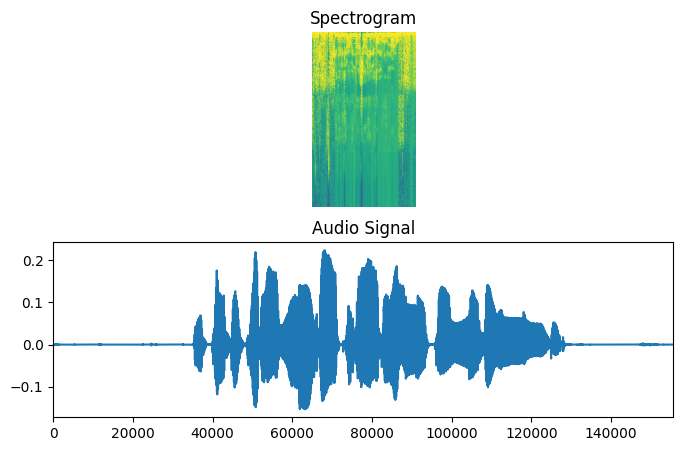

In [8]:
def plot_spectrogram(spectrogram, label):
    plt.clf()
    fig = plt.figure(figsize=(8, 5))
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    print(f'Audio text: {label}')
    ax.set_title('Spectrogram')
    ax.axis("off")
    # Wav
    file = tf.io.read_file(list(X_train)[0])
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Audio Signal")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=48000))
    plt.show()

for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    label = batch[1][0]
    plot_spectrogram(spectrogram, label)


## Define the model <a class='anchor' id='define-model'></a>
<img src="../images/model.svg">

The model is based on a combination of trial and error attempts primarily influenced by these two sources:
- [Automatic Speech Recognition using CTC](https://keras.io/examples/audio/ctc_asr/)
- [Simple audio recognition: Recognizing keywords](https://www.tensorflow.org/tutorials/audio/simple_audio)

In [9]:
# print info needed to set input and output dimensions
print(f'fft_length/2 +1 : {FFT_LENGTH // 2 + 1} output vocabulary size: {char_to_num.vocabulary_size()}')

fft_length/2 +1 : 513 output vocabulary size: 100


In [10]:
def build_model(input_dim, output_dim):
    """
    Build the model
    :param input_dim: input dimension
    :param output_dim: output dimension
    :return: model
    """
    input_spectrogram = layers.Input((None, input_dim), name='Input_Spectrogram')

    x = layers.Reshape((-1, input_dim, 1), name="Reshape_2D")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="Convolution",
    )(x)
    x = layers.BatchNormalization(name="Batch_Normalization")(x)
    x = layers.MaxPooling2D(strides=[2, 2], name="MaxPooling_2D")(x)
    x = layers.ReLU(name="Relu")(x)
    x = layers.Dropout(rate=0.2, name='Droput_1')(x)
    # # LSTM layers
    # x = layers.Flatten(data_format='channels_last')(x)
    x = layers.Reshape((-1, input_dim - 1))(x)
    x = layers.Bidirectional(layers.GRU(128,
                                        activation="tanh",
                                        recurrent_activation="sigmoid",
                                        use_bias=True,
                                        return_sequences=True,
                                        name="GRU_layer"))(x)
    # x = layers.GRU(128, return_sequences=True, name="GRU_layer")(x)
    x = layers.Dropout(rate=0.2, name='Droput_2')(x)

    # Dense layer for output logits
    logits = layers.Dense(output_dim + 1, activation="softmax", name="Output")(x)

    # Model
    model = models.Model(inputs=input_spectrogram, outputs=logits, name='Final_Project_Model')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2), loss=keras.losses.ctc)
    return model

In [11]:
model = build_model(input_dim=FFT_LENGTH // 2 + 1,
                    output_dim=char_to_num.vocabulary_size())
model.summary()

Model: "Final_Project_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Spectrogram (InputLayer)  │ (None, None, 513)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Reshape_2D (Reshape)            │ (None, None, 513, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Convolution (Conv2D)            │ (None, None, 257, 32)  │        14,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batch_Normalization             │ (None, None, 257, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_2D (MaxPooling2D)    │ (None, None, 128, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Relu (ReLU)                     │ (None, None, 128, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Droput_1 (Dropout)              │ (None, None, 128, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 256)      │       493,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Droput_2 (Dropout)              │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, None, 101)      │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,573 (2.04 MB)

 Trainable params: 533,509 (2.04 MB)

 Non-trainable params: 64 (256.00 B)

## Train and Evaluate <a class='anchor' id='train-and-evaluate'></a>

### Define functions to decode and evaluate the output <a class='anchor' id='decode-and-evaluate'></a>

In [13]:
!pip install jiwer

from jiwer import wer

def decode_batch_predictions(pred):
    """
    Decode batch of predictions
    :param pred: predictions
    :return: decoded text
    """
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # tried strategy=beam_search which was slow and did not help with any improvement
    results = keras.ops.ctc_decode(pred, sequence_lengths=input_len, strategy='greedy')[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

def check_predictions(dataset):
    """
    Check predictions
    :param dataset: dataset
    :return: None
    """
    predictions = []
    targets = []
    for batch in dataset:
        X, y = batch
        batch_predictions = model.predict(X, verbose=False)
        batch_predictions = decode_batch_predictions(batch_predictions)
        predictions.extend(batch_predictions)
        for label in y:
            label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
            targets.append(label)
    wer_score = wer(targets, predictions)
    print("-" * 100)
    print(f"Word Error Rate: {wer_score:.4f}")
    print("-" * 100)
    for i in np.random.randint(0, len(predictions), 5):
        print(f"Target    : {targets[i]}")
        print(f"Prediction: {predictions[i]}")
        print("-" * 100)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.1 MB/s eta 0:00:00


### Start training <a class='anchor' id='start-training'></a>

In [27]:
# Define the number of epochs.
epochs = 25
validation_callback = keras.callbacks.LambdaCallback(
    on_epoch_end=check_predictions)
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=3,
                                                        restore_best_weights=True)
save_best_callback = keras.callbacks.ModelCheckpoint('speech_to_text.keras',
                                                     save_best_only=True)
# Train the model
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=epochs,
                    callbacks=[
                        validation_callback,
                        save_best_callback,
                        early_stopping_callback],
                    verbose=False)

TypeError: check_predictions() takes 1 positional argument but 2 were given

## Plot training and validation loss <a class='anchor' id='plot-losses'></a>

In [ ]:
# Plot training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Check predictions <a class='anchor' id='check-predictions'></a>

In [ ]:
check_predictions(validation_dataset.take(5))

## Observations <a class='anchor' id='observations'></a>

The results from the model are pretty dismal. As someone with native fluency in speaking, reading and writing in Telugu and English, I thought this would be a good opportunity to put my newly acquired skills to good use by trying to build a speech recognizer for Telugu speech. As I was warned at the outset, this turned out to be a not so trivial pursuit. However, the learnings that came out of this exercise have been very valuable and I hope to continue working on this project to see if I can build a working prototype in the near future. I will also explore other model types like transformers which seem to be the current choice to build a solution for this type of problem.

## Acknowledgements <a class='anchor' id='acknowledgements'></a>

I would like to take this opportunity to thank Dr. Dmitry Kurochkin and all the wonderful TAs for providing an excellent learning experience.

## References <a class='anchor' id='references'></a>
- [Crowdsourced high-quality Telugu multi-speaker speech data set](https://openslr.org/66/)
<pre>
 @inproceedings{he-etal-2020-open,
    title = {{Open-source Multi-speaker Speech Corpora for Building Gujarati, Kannada, Malayalam,
    Marathi, Tamil and Telugu Speech Synthesis Systems}},
    author = {He, Fei and Chu, Shan-Hui Cathy and Kjartansson, Oddur and Rivera, Clara and Katanova,
    Anna and Gutkin, Alexander and Demirsahin, Isin and Johny, Cibu and Jansche, Martin and Sarin,
    Supheakmungkol and Pipatsrisawat, Knot},
    booktitle = {Proceedings of The 12th Language Resources and Evaluation Conference (LREC)},
    month = may,
    year = {2020},
    address = {Marseille, France},
    publisher = {European Language Resources Association (ELRA)},
    pages = {6494--6503},
    url = {https://www.aclweb.org/anthology/2020.lrec-1.800},
    ISBN = "{979-10-95546-34-4},
  }
 </pre>
- [Automatic Speech Recognition using CTC](https://keras.io/examples/audio/ctc_asr/)
- [Simple audio recognition: Recognizing keywords](https://www.tensorflow.org/tutorials/audio/simple_audio)
- [Audio Data Preparation and Augmentation](https://www.tensorflow.org/io/tutorials/audio#specaugment)
- [Sequence Modeling With CTC](https://distill.pub/2017/ctc/)


## Appendix A - Software and hardware versions<a class='anchor' id='appendix-a'></a>

#### Package versions

In [26]:
print(f'keras version: {keras.__version__}')
print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')

keras version: 3.8.0
tensorflow version: 2.18.0
pandas version: 2.2.2
numpy version: 2.0.2


#### Hardware

https://colab.research.google.com/ Free Tier
<br/>Python 3 Google Compute Engine backend (GPU)